# Model: naive_baseline_0

From notebook '01_check_label_distribution', we know there are 5 assessments:
- Bird Measurer (Assessment)
- Cart Balancer (Assessment)
- Cauldron Filler (Assessment)
- Chest Sorter (Assessment)
- Mushroom Sorter (Assessment)

We also know which is the most likely accuracy_group for each assessment from the train data.

**For this naive baseline, we just use the most likely accuracy_group to do prediction.**

### Results

- Validation qwk_score: 0.37 ~ 0.41
- Test qwk_score: 0.395

In [33]:
import os
from sys import getsizeof
import time
import re
from importlib import reload
import joblib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import xgboost
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor 

from data_util import *
from model_util import *

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [3]:
# Input data path
DATA_DIR  = os.path.join('.', 'input')
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, 'train_labels.csv')

# Read input data
print("\n/########## Load Data ##########/\n")
t0 = time.time()
train_df = pd.read_csv(TRAIN_PATH)
t1 = time.time()
test_df  = pd.read_csv(TEST_PATH)
t2 = time.time()
# train_label_df = pd.read_csv(TRAIN_LABEL_PATH)
print('train_df shape:', train_df.shape, ', load time: {0:.1f} seconds.'.format((t1 - t0)))
print('test_df shape:', test_df.shape, ', load time: {0:.1f} seconds.'.format((t2 - t1)))


/########## Load Data ##########/

train_df shape: (11341042, 11) , load time: 65.8 seconds.
test_df shape: (1156414, 11) , load time: 4.4 seconds.


# Process Data

- **train_df, test_df**: raw data
- **train_label_df, test_label_df**: dataframes recording each assessment result.
- **train_proc_df, test_proc_df**: dataframes recording features extracted from each session.

In [5]:
# Setup directory
PROC_DIR = os.path.join('.', 'processed')
if not os.path.exists(PROC_DIR):
    os.makedirs(PROC_DIR)
    
TRAIN_LABEL_PATH_ = os.path.join(PROC_DIR, 'train_labels_sortByTime.csv')
TEST_LABEL_PATH_  = os.path.join(PROC_DIR, 'test_labels_sortByTime.csv')
TRAIN_PROC_PATH = os.path.join(PROC_DIR, 'train_proc.csv')
TEST_PROC_PATH  = os.path.join(PROC_DIR, 'test_proc.csv')

# Get label_df
print("\n/########## Extract label_df ##########/\n")
get_label_csv(train_df, TRAIN_LABEL_PATH_, is_test=False)
get_label_csv(test_df, TEST_LABEL_PATH_, is_test=True)
train_label_df = pd.read_csv(TRAIN_LABEL_PATH_)
test_label_df  = pd.read_csv(TEST_LABEL_PATH_)

TRAIN_USERS = train_df['installation_id'].unique()
TRAIN_USERS_wLabel = train_label_df['installation_id'].unique()
TEST_USERS  = test_df['installation_id'].unique()
TEST_USERS_wMultiAssess = test_label_df.dropna()['installation_id'].unique()    # can be used as part of train.
print('TRAIN_USERS num: ', len(TRAIN_USERS))
print('TRAIN_USERS_wLabel num: ', len(TRAIN_USERS_wLabel))
print('TEST_USERS num: ', len(TEST_USERS))
print('TEST_USERS_wMultiAssess num: ', len(TEST_USERS_wMultiAssess))


/########## Extract label_df ##########/

Finished extracting labels. Time: 62.3 seconds.
Finished extracting labels. Time: 5.5 seconds.
TRAIN_USERS num:  17000
TRAIN_USERS_wLabel num:  3614
TEST_USERS num:  1000
TEST_USERS_wMultiAssess num:  557


# Validation

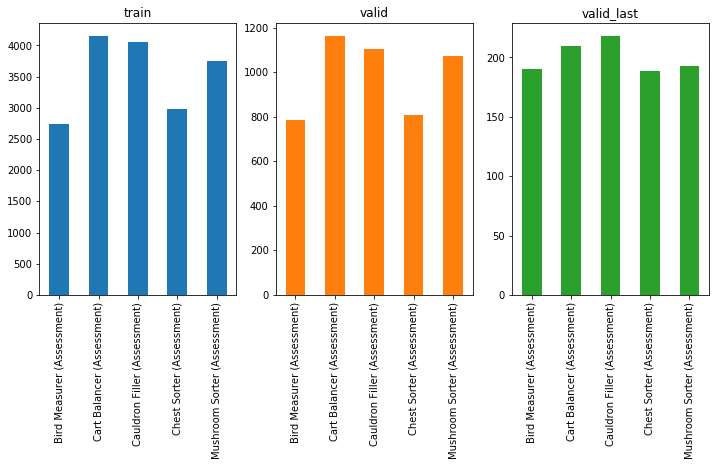

In [87]:
# Sampling 1000 samples as validation set 
valid_num = 1000
valid_users = np.random.choice(TRAIN_USERS_wLabel, valid_num, replace=False)
valid_label_df = train_label_df[train_label_df['installation_id'].isin(valid_users)]
valid_label_df_last = valid_label_df.groupby('installation_id').tail(1)

# Plot the histogram of assessment types.
df_assessment_counts = pd.DataFrame(columns=['train', 'valid', 'valid_last'])
df_assessment_counts['train'] = pd.Series(train_label_df['title'].values).value_counts().sort_index()
df_assessment_counts['valid'] = pd.Series(valid_label_df['title'].values).value_counts().sort_index()
df_assessment_counts['valid_last'] = pd.Series(valid_label_df_last['title'].values).value_counts().sort_index()
_ = df_assessment_counts.plot(kind='bar', figsize=(12, 5), subplots=True, layout=(1,3), legend=False)

In [88]:
# Prediction
assessment_dict = {
    'Bird Measurer (Assessment)' : 0,
    'Cart Balancer (Assessment)' : 3,
    'Cauldron Filler (Assessment)' : 3,
    'Chest Sorter (Assessment)': 0,
    'Mushroom Sorter (Assessment)': 3
}

y_valid_truth = valid_label_df_last['accuracy_group'].values
y_valid_pred  = [assessment_dict[assessment] for assessment in valid_label_df_last['title']]
res_df = pd.DataFrame()
res_df['title'] = valid_label_df_last['title']
res_df['accuracy_group_truth'] = y_valid_truth
res_df['accuracy_group_pred'] = y_valid_pred

Assessment = Bird Measurer (Assessment): qwk_score = 0.00
Assessment = Cart Balancer (Assessment): qwk_score = 0.00
Assessment = Cauldron Filler (Assessment): qwk_score = 0.00
Assessment = Chest Sorter (Assessment): qwk_score = 0.00
Assessment = Mushroom Sorter (Assessment): qwk_score = 0.00
Overall: r2_score = -0.43
Overall: qwk_score = 0.37


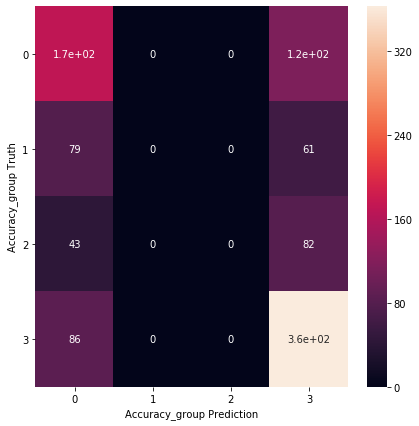

In [89]:
for assessment in assessment_dict:
    assessment_truth = res_df[res_df['title'] == assessment]['accuracy_group_truth'].values
    assessment_pred  = res_df[res_df['title'] == assessment]['accuracy_group_pred'].values
    assessment_qwk = cohen_kappa_score(assessment_truth, assessment_pred, weights='quadratic')
    print('Assessment = {}: qwk_score = {:.2f}'.format(assessment, assessment_qwk))

r2 = r2_score(y_valid_truth, y_valid_pred) 
print('Overall: r2_score = {:.2f}'.format(r2))
qwk_score = cohen_kappa_score(y_valid_truth, y_valid_pred, weights='quadratic')
print('Overall: qwk_score = {:.2f}'.format(qwk_score))
plot_acc_group_cm(y_valid_truth, y_valid_pred)

# Test

In [83]:
test_label_df_last = test_label_df.groupby('installation_id').tail(1)
submission_df = pd.DataFrame()
submission_df['installation_id'] = test_label_df_last['installation_id'].values
submission_df['accuracy_group']  = [assessment_dict[assessment] for assessment in test_label_df_last['title']]
submission_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,3


In [84]:
OUTPUT_DIR  = os.path.join('.', 'output')
submission_df.to_csv('submission.csv', index=False)